# Gene Set Recovery Results

*State of the Interactomes: an evaluation of molecular networks for generating biological insights.* Wright, SN et al. [https://doi.org/10.1101/2024.04.26.587073]  
This notebook contains code and results related to:
* Figure 3B-D
* Supplemental Figure 5A-E

**Note: due to the size of network data sets utilized in this study, this notebook draws on summarized results rather than re-evaluating all networks directly.**

## Setup

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import seaborn as sns
from neteval.network_statistics import NetworkStats, load_network_names
from neteval.data_import_export_tools import load_node_sets
from neteval.gene_set_recovery_results import *
from statsmodels.stats.multitest import fdrcorrection
from matplotlib.cm import ScalarMappable
from matplotlib.colors import ListedColormap
from neteval.network_statistics import NetworkStats, load_network_names
from scipy.stats import spearmanr

/cellar/users/snwright/anaconda3/envs/pcnet_py3/lib/python3.10/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.7) or chardet (5.1.0)/charset_normalizer (2.0.7) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [3]:

plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams.update({'font.size': 7})
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams.update({'font.size': 7})
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['hatch.linewidth'] = 0.5
plt.rcParams['xtick.major.width'] = 0.4
plt.rcParams['ytick.major.width'] = 0.4
plt.rcParams['xtick.minor.width'] = 0.3
plt.rcParams['ytick.minor.width'] = 0.3
plt.rcParams['legend.frameon'] = False
plt.rcParams['xtick.major.size'] = 3
plt.rcParams['ytick.major.size'] = 3
plt.rcParams['xtick.minor.size'] = 2
plt.rcParams['ytick.minor.size'] = 2
plt.rcParams['xtick.major.pad'] = 1
plt.rcParams['ytick.major.pad'] = 1
plt.rcParams['axes.labelpad'] = 1
plt.rcParams['patch.linewidth'] = 0.25

In [4]:
gitdir = os.path.expanduser('~/Git/Network_Evaluation_Tools/')
figdir = os.path.join(gitdir, 'StateOfTheInteractomes_Notebooks/Figures/')
evaldir = os.path.join(gitdir, 'Data/example_outputs/')
datadir = os.path.join(gitdir, 'Data/')
network_names = load_network_names(os.path.join(gitdir, 'StateOfTheInteractomes_Notebooks/Data/network_names_final.txt'))
genesets = [ 'gwas', 'disgen', 'gwas_230727', 'exp_genesets']
geneset_names = {'gwas' : 'Genetic', 
                'disgen':'Literature',
                'gwas_230727':'Genetic 2023+',
                'exp_genesets':'Experimental'}

## Example Analysis

In [5]:
pref_file = os.path.join(datadir, 'example_prefix_file.txt')

In [6]:
with open(pref_file, 'r') as f:
    prefixes = [pref.strip() for pref in f.readlines()]
    
stats = NetworkStats(pref_file, datadir=evaldir)
example_network_names = load_network_names(gitdir+"Data/example_network_names.txt")

In [7]:
gsr_results = EvaluationResults(evaldir, prefixes, genesets = genesets, metrics = ['AUPRC', 'Performance', 'Gain'], verbose=True)
gsr_results.set_network_names(example_network_names)

For the Genetic 2023+ gene sets, keep only those after the cutoff date

In [8]:
# for the Gnetkeep only the gwsa that are after the cutoff date
drop_from_recent_gwas = [g for g in gsr_results.results['Performance']['gwas_230727'].index if '2023-07' not in g]
for met in gsr_results.results:
    gsr_results.results[met]['gwas_230727'].drop(index=drop_from_recent_gwas, inplace=True)

Perform size adjustment of recovery results and then rank all networks.  
Note: this is performed for illustrative purposes only. It is recommended that at least 10 networks be evaluated for using size-adjustment to avoid convergence issues. 

In [9]:
gsr_results.size_adjusted_performances(sizes=stats.network_edge_counts, na_option='center')
gsr_results.rank_all(na_option='center')

/cellar/users/snwright/anaconda3/envs/pcnet_py3/lib/python3.10/site-packages/sklearn/linear_model/_huber.py:332: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/cellar/users/snwright/anaconda3/envs/pcnet_py3/lib/python3.10/site-packages/sklearn/linear_model/_huber.py:332: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/cellar/users/snwright/anaconda3/envs/pcnet_py3/lib/python3.10/site-packages/sklearn/linear_model/_huber.py:332: ConvergenceWarning: lbfgs faile

In [10]:
gsr_results.results['Performance']['exp_genesets']

,dip,pid2,wan
Gou24_lung,NaN,NaN,0.419803
Hashimoto24,6.701156,-0.792871,0.330971
Kumbrink24_1v2,NaN,21.542769,NaN
Kumbrink24_2v3,167.469451,12.108419,NaN
Qian24_DEG_PANoptosis,100.953805,NaN,NaN
Reed24_Catabolic process module,6.007370,1.430714,3.005223
Reed24_Cell cycle module,20.117417,30.765690,18.245169
Reed24_Cellular response to stimulus module,18.986215,1.634364,NaN
Reed24_Endoplasmic reticulum module,33.901985,173.489417,16.313287
Reed24_Leukocyte module,45.304503,1.000865,53.796605


In [11]:
gsr_results.results['Performance_SzAdj']['disgen']

,dip,pid2,wan
ACTH-Secreting Pituitary Adenoma,8.267254e-11,-1.287432e-08,NaN
AICARDI-GOUTIERES SYNDROME,6.063691e-04,1.355613e-03,-9.368479
AIDS related complex,8.575010e-08,7.185804e-08,NaN
AMYOTROPHIC LATERAL SCLEROSIS 1,6.899246e-06,6.915787e-06,-1.273928
ATRICHIA WITH PAPULAR LESIONS,4.113282e-09,1.371571e-08,NaN
...,...,...,...
oligodendroglioma,-4.332723e-02,-2.162417e-02,2.075810
psychological distress,-2.420546e-09,-1.943298e-09,NaN
"stage, non-small cell lung cancer",3.593005e-05,1.688245e-05,-1.847012
synovial sarcoma,-2.890594e-06,-7.259157e-06,0.920294


In [12]:
gsr_results.rankings

,AUPRC-gwas,AUPRC-disgen,AUPRC-gwas_230727,AUPRC-exp_genesets,Performance-gwas,Performance-disgen,Performance-gwas_230727,Performance-exp_genesets,Gain-gwas,Gain-disgen,...,AUPRC_SzAdj-gwas_230727,AUPRC_SzAdj-exp_genesets,Performance_SzAdj-gwas,Performance_SzAdj-disgen,Performance_SzAdj-gwas_230727,Performance_SzAdj-exp_genesets,Gain_SzAdj-gwas,Gain_SzAdj-disgen,Gain_SzAdj-gwas_230727,Gain_SzAdj-exp_genesets
dip,0.267327,0.202326,0.078947,-0.227273,-0.435644,-0.684884,-0.631579,-0.318182,-0.396040,-0.683721,...,-0.578947,-0.409091,-0.247525,-0.327907,-0.342105,-0.318182,-0.346535,-0.416279,-0.500000,-0.045455
pid2,-0.511111,-0.815476,-0.722222,-0.041667,0.300000,0.472619,0.416667,0.208333,0.111111,0.390476,...,-0.111111,-0.041667,-0.066667,-0.084524,-0.194444,0.041667,-0.066667,-0.117857,0.000000,-0.041667
wan,0.322034,0.754801,0.657143,0.375000,0.288136,0.283604,0.257143,0.125000,0.508475,0.384047,...,0.742857,0.625000,0.525424,0.521418,0.571429,0.375000,0.694915,0.675037,0.542857,0.125000


## Fig3B - Visualization of performance of all networks for Literature and Genetic gene sets.

In [13]:
gsr_full_results = pd.read_csv(gitdir+'StateOfTheInteractomes_Notebooks/Data/TableS3.txt', index_col=None, sep='\t')

In [14]:
full_network_rankings = pd.read_csv(gitdir+'StateOfTheInteractomes_Notebooks/Data/Fig3B_all_network_ranks.csv', index_col=0)

In [15]:
full_network_rankings['order'] = full_network_rankings['Performance-'+'disgen'].rank(ascending=False, na_option='top', method='first')
full_network_rankings = full_network_rankings.sort_values(by='order', ascending=False)
full_network_rankings['bar_y'] = full_network_rankings['order'] +1.5
rank_dict = {j:i+1 for i, j in enumerate(range(-22, 23))}
min(rank_dict.keys()), max(rank_dict.keys())

(-22, 22)

In [16]:
gsr_full_results.head()

,Network,GeneSet,Disease,AUPRC,Performance,Gain,AUPRC_SzAdj,Performance_SzAdj,Gain_SzAdj,Unnamed: 9
0,APID,Genetic,EFO_0000095,0.04153,3.29163,0.03780,-0.00169,-2.21695,-0.01703,NaN
1,APID,Genetic,EFO_0000183,0.02635,1.13930,0.00609,-0.00152,0.15588,0.00074,NaN
2,APID,Genetic,EFO_0000195,0.01745,7.51011,0.25787,-0.00583,0.11463,0.05723,NaN
3,APID,Genetic,EFO_0000274,0.01563,2.74711,0.04951,-0.00816,-3.14996,-0.08434,NaN
4,APID,Genetic,EFO_0000319,0.01130,0.53050,0.01792,-0.00430,-1.34129,-0.02821,NaN


Create the visualization

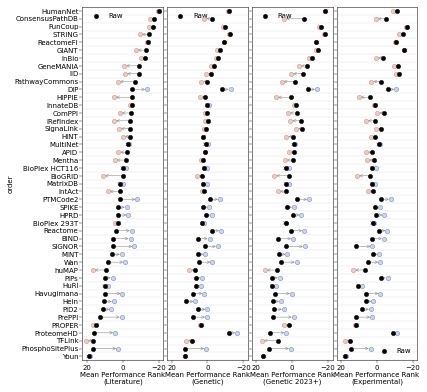

In [17]:
_, [ax2, ax1, ax3, ax4] = plt.subplots(nrows=1, ncols=4, figsize=(6, 6.5), sharey=True, gridspec_kw={'wspace':0.05})

for j, ax in enumerate([ax1, ax2, ax3, ax4]):
    geneset= genesets[j]
    plt.sca(ax)
    ax.invert_xaxis()
    full_network_rankings['direction'] = (full_network_rankings["Performance-SzAdj-"+geneset] - full_network_rankings["Performance-"+geneset]) > 0
    rank_max = (rank_dict[(np.floor(full_network_rankings["Performance-"+geneset].max())) ]//5) * 5
    rank_min = (rank_dict[(np.ceil(full_network_rankings["Performance-"+geneset].min())) ]//5) * 5
    sns.scatterplot(full_network_rankings[full_network_rankings['direction']==True], x="Performance-SzAdj-"+geneset, y='order', color='lightgrey', ax=ax, s=20, zorder=12, edgecolor='tomato')
    sns.scatterplot(full_network_rankings[full_network_rankings['direction']==False], x="Performance-SzAdj-"+geneset, y='order', color='lightgrey', ax=ax, s=20, zorder=12, edgecolor='royalblue')
    sns.scatterplot(full_network_rankings, x="Performance-"+geneset, y='order', color='black', edgecolor='black', ax=ax, zorder=100, s=20, label='Raw')
    # add arrows between the pairs of points
    for i in range(len(full_network_rankings)):
        # create a pallete for the arrows
        if full_network_rankings['Performance-SzAdj-'+geneset][i] < full_network_rankings['Performance-'+geneset][i]:
            ax.annotate("", xy=(full_network_rankings['Performance-'+geneset][i], full_network_rankings['order'][i]), 
                    xytext=(full_network_rankings['Performance-SzAdj-'+geneset][i], full_network_rankings['order'][i]), 
                    arrowprops=dict(arrowstyle="<-", color='grey', lw=0.5))
        else:
            ax.annotate("", xy=(full_network_rankings['Performance-'+geneset][i], full_network_rankings['order'][i]), 
                    xytext=(full_network_rankings['Performance-SzAdj-'+geneset][i], full_network_rankings['order'][i]), 
                    arrowprops=dict(arrowstyle="<-", color='grey', lw=0.5))
    # add a horizontal grid between points
    for i in range(len(full_network_rankings)):
        ax.axhline(y=full_network_rankings['order'][i]-0.5, color='grey', lw=0.1, zorder=0)
    plt.ylim(0.5, len(full_network_rankings)+.5)
    # reorder the index of full_network_rankings based on the order column
    full_network_rankings = full_network_rankings.sort_values(by='order', ascending=False)
    _ = plt.yticks(full_network_rankings['order'], labels= full_network_rankings.index)
    plt.xlabel("Mean Performance Rank\n("+geneset_names[geneset]+")")
    ax.set_xlim(22.5, -22.5)
# map tick labels using the network names
_ = ax1.set_yticklabels([network_names[x] for x in full_network_rankings.index])
ax1.set_ylabel("Network")
plt.savefig(figdir + "Fig3B_full_performance_results.jpg", dpi=300, bbox_inches="tight")

## Fig 3C - Correlations of performance between different gene sets sources

Calculate the correlations

In [18]:
correlations = full_network_rankings.loc[:, ["Performance-"+geneset for geneset in genesets]].corr(method=lambda x, y: spearmanr(x, y)[0])
pvals = full_network_rankings.loc[:, ["Performance-"+geneset for geneset in genesets]].corr(method=lambda x, y: spearmanr(x, y)[1])

Plot the correlations

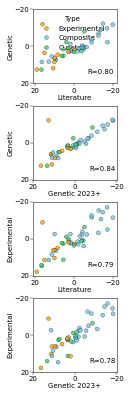

In [19]:
_, [ax1, ax2, ax3, ax4] = plt.subplots(nrows=4, ncols=1, figsize=(1.5,5*4/3), gridspec_kw={'hspace':0.3})
sns.scatterplot(full_network_rankings, x="Performance-"+genesets[1], y="Performance-"+genesets[0], hue='Type', edgecolor='black', zorder=100, s=15, 
                alpha=0.8, palette=['#ffa500', '#73c7e7', '#44cf6c'], hue_order=['Experimental', 'Composite', 'Curated'], ax=ax1, legend=True)
r1 = correlations["Performance-"+genesets[1]]["Performance-"+genesets[0]]
ax1.set_xlabel(geneset_names[genesets[1]])
ax1.set_ylabel(geneset_names[genesets[0]])
sns.scatterplot(full_network_rankings, x="Performance-"+genesets[2], y="Performance-"+genesets[0], hue='Type', edgecolor='black', zorder=100, s=15, 
                alpha=0.8, palette=['#ffa500', '#73c7e7', '#44cf6c'], hue_order=['Experimental', 'Composite', 'Curated'], ax=ax2, legend=False)
r2 = correlations["Performance-"+genesets[2]]["Performance-"+genesets[0]]
ax2.set_xlabel(geneset_names[genesets[2]])
ax2.set_ylabel(geneset_names[genesets[0]])
sns.scatterplot(full_network_rankings, x="Performance-"+genesets[1], y="Performance-"+genesets[3], hue='Type', edgecolor='black', zorder=100, s=15, 
                alpha=0.8, palette=['#ffa500', '#73c7e7', '#44cf6c'], hue_order=['Experimental', 'Composite', 'Curated'], ax=ax3, legend=False)
r3 = correlations["Performance-"+genesets[1]]["Performance-"+genesets[3]]
ax3.set_xlabel(geneset_names[genesets[1]])
ax3.set_ylabel(geneset_names[genesets[3]])

sns.scatterplot(full_network_rankings, x="Performance-"+genesets[2], y="Performance-"+genesets[3], hue='Type', edgecolor='black', zorder=100, s=15, 
                alpha=0.8, palette=['#ffa500', '#73c7e7', '#44cf6c'], hue_order=['Experimental', 'Composite', 'Curated'], ax=ax4, legend=False)
r4 = correlations["Performance-"+genesets[2]]["Performance-"+genesets[3]]
ax4.set_xlabel(geneset_names[genesets[2]])
ax4.set_ylabel(geneset_names[genesets[3]])

for i, ax in enumerate([ax1, ax2, ax3, ax4]):
    r=[r1,r2,r3,r4][i]
    ax.annotate(f"R={r:.2f}", xy=(-7,15))

for ax in [ax1, ax2, ax3, ax4]:
    ax.set_xticks([-20, 0,  20])
    ax.set_yticks([-20, 0, 20])

ax1.invert_xaxis()
ax1.invert_yaxis()
ax2.invert_xaxis()
ax2.invert_yaxis()
ax3.invert_xaxis()
ax3.invert_yaxis()
ax4.invert_xaxis()
ax4.invert_yaxis()
plt.savefig(figdir + "Fig3C_Performance_correlations.jpg", dpi=300, bbox_inches="tight")

## Fig 3D - Interaction-type-specific performance results

In [20]:
type_specific_results = pd.read_csv(gitdir+'StateOfTheInteractomes_Notebooks/Data/Fig3D_type_specific_results.csv')

In [21]:
type_specific_results[ type_specific_results['GeneSet']=='Performance_gwas']

,index,Network,Performance,parent,InteractionType,GeneSet
0,493,GM_domain,164.223463,GeneMANIA,Domain,Performance_gwas
1,1213,GM_predicted,102.958152,GeneMANIA,Orthology,Performance_gwas
2,395,GM_domain,67.391454,GeneMANIA,Domain,Performance_gwas
3,435,GM_domain,50.938449,GeneMANIA,Domain,Performance_gwas
4,502,GM_domain,46.520458,GeneMANIA,Domain,Performance_gwas
...,...,...,...,...,...,...
1602,255,humannet.v3.pg,-0.978341,HumanNet,Orthology,Performance_gwas
1603,0,humannet.v3.xc,39.139973,HumanNet,Baseline,Performance_gwas
1604,1,humannet.v3.xc,25.143328,HumanNet,Baseline,Performance_gwas
1605,2,genemania.2021_90,17.393137,GeneMANIA,Baseline,Performance_gwas


In [22]:
type_specific_results[(~type_specific_results.Network.isin(['GM_genetic', 'GM_coexp_90', 'humannet.v3.gn'])) & (type_specific_results['GeneSet']=='Performance_gwas')]

,index,Network,Performance,parent,InteractionType,GeneSet
0,493,GM_domain,164.223463,GeneMANIA,Domain,Performance_gwas
1,1213,GM_predicted,102.958152,GeneMANIA,Orthology,Performance_gwas
2,395,GM_domain,67.391454,GeneMANIA,Domain,Performance_gwas
3,435,GM_domain,50.938449,GeneMANIA,Domain,Performance_gwas
4,502,GM_domain,46.520458,GeneMANIA,Domain,Performance_gwas
...,...,...,...,...,...,...
1602,255,humannet.v3.pg,-0.978341,HumanNet,Orthology,Performance_gwas
1603,0,humannet.v3.xc,39.139973,HumanNet,Baseline,Performance_gwas
1604,1,humannet.v3.xc,25.143328,HumanNet,Baseline,Performance_gwas
1605,2,genemania.2021_90,17.393137,GeneMANIA,Baseline,Performance_gwas


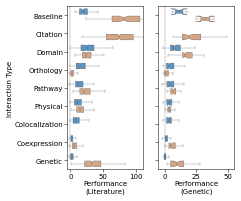

In [23]:
_, [ax, ax1] = plt.subplots(nrows=1, ncols=2,figsize=(3,3), sharey=True)
ax = sns.boxplot(data=type_specific_results[(~type_specific_results.Network.isin(['GM_genetic', 'GM_coexp_90', 'humannet.v3.gn'])) & (type_specific_results['GeneSet']=='Performance_disgen')], 
                    y='InteractionType', x='Performance', hue='parent', linewidth=0.25,fliersize=0,notch=True, ax = ax, 
                    order=['Baseline', 'Citation', 'Domain', 'Orthology', 'Pathway', 'Physical', 'Colocalization', 'Coexpression', 'Genetic'], zorder=10,
                    legend=False, palette=['#5e94c0','#d2a686' ], gap=0.2, linecolor='#343a40', saturation=1)
ax.tick_params(labelsize=7)
ax.set_ylabel("Interaction Type", fontsize=7)
ax.set_xlabel("Performance\n(Literature)", fontsize=7)
# plot vertical line on ax
ax.vlines(x=0, ymin=-1, ymax=8, color='black', lw=0.25, zorder=0, linestyles='--')
ax.set_xlim((-5, 110))
ax.set_ylim(7.5, -0.5)
_ =ax.set_xticks([0,50,100])

ax1 = sns.boxplot(data=type_specific_results[(~type_specific_results.Network.isin(['GM_genetic', 'GM_coexp_90', 'humannet.v3.gn'])) & (type_specific_results['GeneSet']=='Performance_gwas')], 
                    y='InteractionType', x='Performance', hue='parent', linewidth=0.25,fliersize=0,notch=True, ax = ax1, 
                    order=['Baseline', 'Citation', 'Domain', 'Orthology', 'Pathway', 'Physical', 'Colocalization', 'Coexpression', 'Genetic'], zorder=10,
                    legend=False, palette=['#5e94c0','#d2a686' ], gap=0.2, linecolor='#343a40', saturation=1)

ax1.tick_params(labelsize=7)

ax1.set_xlabel("Performance\n(Genetic)", fontsize=7)

ax1.vlines(x=0, ymin=-1, ymax=8, color='black', lw=0.25, zorder=0, linestyles='--')
ax1.set_xlim((-5, 55))
ax1.set_ylim(8.5, -0.5)
_ =ax1.set_xticks([0,25, 50])


ax1.tick_params(labelsize=7, width=0.5)
ax.tick_params(labelsize=7, width=0.5)

plt.savefig(figdir+"Fig3D_type_specific_results.jpg", bbox_inches='tight', dpi=300)

## Supplemental Figures

### SFig 5A - Summary statistics of gene set recovery


#### AUPRC

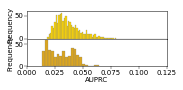

In [24]:
_, [ax1, ax2] = plt.subplots(nrows=2, ncols=1, figsize=(2.5, 1), sharex=True, gridspec_kw={'hspace':0})
gsr_full_results[gsr_full_results.GeneSet == geneset_names[genesets[1]]].groupby('Disease').AUPRC.median().plot(kind='hist',bins=100,
                                                                ax=ax1, edgecolor='grey', color='gold', linewidth=0.25, density=False)
gsr_full_results[gsr_full_results.GeneSet == geneset_names[genesets[0]]].groupby('Disease').AUPRC.median().plot(kind='hist',bins=20,
                                                                ax=ax2, edgecolor='grey', color='goldenrod', linewidth=0.25, density=False)


plt.xlim(0, 0.125)
ax2.set_xlabel("AUPRC")
ax1.tick_params(axis='x', length=0)
plt.savefig(figdir + "FigS5A_auprc_histograms.jpg", dpi=300, bbox_inches="tight")

#### Performance

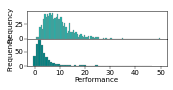

In [25]:
_, [ax1, ax2] = plt.subplots(nrows=2, ncols=1, figsize=(2.5, 1), sharex=True, gridspec_kw={'hspace':0})
gsr_full_results[gsr_full_results.GeneSet == geneset_names[genesets[1]]].groupby('Disease').Performance.median().plot(kind='hist',bins=100,
                                                                ax=ax1, edgecolor='grey', color='lightseagreen', linewidth=0.25, density=False)
gsr_full_results[gsr_full_results.GeneSet == geneset_names[genesets[0]]].groupby('Disease').Performance.median().plot(kind='hist',bins=50,
                                                                ax=ax2, edgecolor='grey', color='teal', linewidth=0.25, density=False)


ax2.set_xlabel("Performance")
ax1.tick_params(axis='x', length=0)
plt.savefig(figdir + "FigS5A_performance_histograms.jpg", dpi=300, bbox_inches="tight")

#### Performance Gain

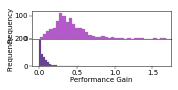

In [26]:
_, [ax1, ax2] = plt.subplots(nrows=2, ncols=1, figsize=(2.5, 1), sharex=True, gridspec_kw={'hspace':0})
gsr_full_results[gsr_full_results.GeneSet == geneset_names[genesets[1]]].groupby('Disease').Gain.median().plot(kind='hist',bins=100,
                                                                ax=ax1, edgecolor='grey', color='mediumorchid', linewidth=0.25, density=False)
gsr_full_results[gsr_full_results.GeneSet == geneset_names[genesets[0]]].groupby('Disease').Gain.median().plot(kind='hist',bins=20,
                                                                ax=ax2, edgecolor='grey', color='rebeccapurple', linewidth=0.25, density=False)

plt.xlim(-0.1, 1.75)
ax2.set_xlabel("Performance Gain")
ax1.tick_params(axis='x', length=0)
plt.savefig(figdir + "FigS5A_gain_histograms.jpg", dpi=300, bbox_inches="tight")

#### Network Coverage

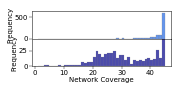

In [27]:
_, [ax1, ax2] = plt.subplots(nrows=2, ncols=1, figsize=(2.5, 1), sharex=True,  gridspec_kw={'hspace':0})
gsr_full_results[gsr_full_results.GeneSet == geneset_names[genesets[1]]].value_counts('Disease').plot(kind='hist',bins=[i for i in range(1, 46)],
                                                                ax=ax1, edgecolor='grey', color='cornflowerblue', linewidth=0.25, density=False)
gsr_full_results[gsr_full_results.GeneSet == geneset_names[genesets[0]]].value_counts('Disease').plot(kind='hist',bins=[i for i in range(1, 46)],
                                                                ax=ax2, edgecolor='grey', color='darkblue', linewidth=0.25, density=False,alpha=0.7)
ax2.set_ylim(0, 45)
ax2.set_xlabel("Network Coverage")
ax1.tick_params(axis='x', length=0)
plt.savefig(figdir + "FigS5A_coverage_histograms.jpg", dpi=300, bbox_inches="tight")

#### Gene Set Sizes

In [28]:
disgen_sets = load_node_sets(os.path.join(gitdir, 'Data', 'disgen.genesets'))
gwas_sets = load_node_sets(os.path.join(gitdir, 'Data', 'gwas.genesets'))
disgen_sizes = {net:len(disgen_sets[net]) for net in disgen_sets}
gwas_sizes = {net:len(gwas_sets[net]) for net in gwas_sets}

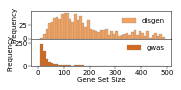

In [29]:
_, [ax1, ax2] = plt.subplots(nrows=2, ncols=1, figsize=(2.5, 1), sharex=True,  gridspec_kw={'hspace':0})
pd.DataFrame({'disgen':disgen_sizes}).plot(kind='hist', bins=[i*10 for i in range(0, 50)], ax=ax1, edgecolor='grey', color='sandybrown', linewidth=0.25, density=False)
pd.DataFrame({'gwas':gwas_sizes}).plot(kind='hist', bins=[i*10 for i in range(0, 50)], ax=ax2, edgecolor='grey', color='chocolate', alpha=1, linewidth=0.25, density=False)
#plt.xlim(-0.1, 1.75)
ax2.set_ylim(0, 300)
ax2.set_xlabel("Gene Set Size")
ax1.tick_params(axis='x', length=0)
plt.savefig(figdir + "FigS5A_sizes_histograms.jpg", dpi=300, bbox_inches="tight")

### SFig 5B - Performance for reduced versus original gene sets

In [30]:
reduced_er = {'Genetic (reduced)': gsr_full_results[gsr_full_results.GeneSet=='Genetic (Reduced)'].pivot_table(columns='Network', index='Disease', values='Performance'),
             'Literature (reduced)':gsr_full_results[gsr_full_results.GeneSet=='Literature (Reduced)'].pivot_table(columns='Network', index='Disease', values='Performance'),
              'Literature':gsr_full_results[gsr_full_results.GeneSet=='Literature'].pivot_table(columns='Network', index='Disease', values='Performance'),
              'Genetic':gsr_full_results[gsr_full_results.GeneSet=='Genetic'].pivot_table(columns='Network', index='Disease', values='Performance')
             }

In [31]:
size_stats = pd.read_csv(os.path.join(gitdir, 'StateOfTheInteractomes_Notebooks/Data/Fig1B_network_sizes.csv'), index_col=0)
edge_dict = size_stats.set_index('Name')['Interaction Count'].to_dict()
node_dict = size_stats.set_index('Name')['Gene Count'].to_dict()

In [32]:
def plot_size_correlations(reduced_er, group1, group2, edge_dict, node_dict, ax=None):
    plot_df = reduced_er[group1].melt(ignore_index=False, var_name="Network", value_name="Performance").reset_index().rename(columns={"index":'Geneset'})
    plot_df['EdgeCount'] = plot_df.Network.apply(lambda x: edge_dict[x])
    plot_df['NodeCount'] = plot_df.Network.apply(lambda x: node_dict[x])
    plot_df_full = reduced_er[group2].melt(ignore_index=False, var_name="Network", value_name="Performance").reset_index().rename(columns={"index":'Geneset'})
    plot_df_full['EdgeCount'] = plot_df_full.Network.apply(lambda x: edge_dict[x])
    plot_df_full['NodeCount'] = plot_df_full.Network.apply(lambda x: node_dict[x])
    sns.regplot(data = plot_df.groupby('Network').mean().reset_index(), x='EdgeCount', y='Performance', 
                logx=True, ci=95, label=group1, ax=ax, scatter_kws={'s':10}, line_kws={'linewidth':0.75})
    sns.regplot(data = plot_df_full.groupby('Network').mean().reset_index(), x='EdgeCount', y='Performance', 
                logx=True, ci=95, label=group2, ax=ax, scatter_kws={'s':10}, line_kws={'linewidth':0.75})
    if ax is None:
        ax = plt.gca()
    ax.set_ylabel('Mean Performance')
    ax.set_xscale('log')
    ax.set_xlabel('Interaction Count')

    ax.legend()
    return plot_df.groupby('Network').mean(), plot_df_full.groupby('Network').mean()

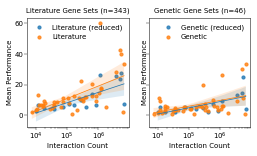

In [33]:
_ , [ax1, ax2] = plt.subplots(1, 2, figsize=(4,2), sharey=True)
_ = plot_size_correlations(reduced_er, 'Literature (reduced)', 'Literature', edge_dict, node_dict, ax=ax1)
_ = ax1.set_title('Literature Gene Sets (n=343)', fontsize=7)
_ = plot_size_correlations(reduced_er, 'Genetic (reduced)', 'Genetic', edge_dict, node_dict, ax=ax2)
_ = ax2.set_title('Genetic Gene Sets (n=46)', fontsize=7)
plt.savefig(figdir + "FigS5B_reduced_geneset_scatters.jpg", dpi=300, bbox_inches="tight")

### SFig 5C - Slopes of size-adjusted performance for reduced gene sets

In [34]:
## Load fit data
slope_data = pd.read_csv(os.path.join(gitdir, 'StateOfTheInteractomes_Notebooks/Data/FigS5C_slope_data.tsv'), sep='\t')

In [35]:
def plot_slope_hists(slope_data, geneset, name1, name2, ax=None):
    combined_data = slope_data[slope_data.GeneSet==geneset].melt(id_vars=['Disease', 'GeneSet'], value_name='Slope', var_name=geneset)
    sns.histplot(data=combined_data, x='Slope', hue=geneset, kde=True, ax=ax, bins=[i for i in range(-5, 30)], alpha=0.3)
    ax.set_ylabel('Gene Set Count')
    return combined_data.groupby(geneset).Slope.median()

Medians:  Literature
Slope_Full       7.185544
Slope_Reduced    4.540508
Name: Slope, dtype: float64
Medians:  Genetic
Slope_Full       3.923959
Slope_Reduced    1.504175
Name: Slope, dtype: float64


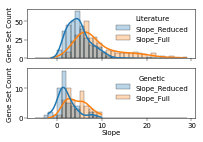

In [36]:
_, [ax1, ax2] = plt.subplots(2, 1, figsize=(3,2), sharex=True)
x1 = plot_slope_hists(slope_data, 'Literature', 'Reduced', 'Original', ax=ax1)
print('Medians: ', x1)
x2 = plot_slope_hists(slope_data, 'Genetic', 'Reduced', 'Original', ax=ax2)
print('Medians: ', x2)
plt.savefig(figdir + "FigS5C_reduced_geneset_slope_histograms.jpg", dpi=300, bbox_inches="tight")

Wilcoxon test

In [37]:
from scipy.stats import wilcoxon
def perform_paired_slope_test(slope_data, geneset):
    combined_data = slope_data[slope_data.GeneSet==geneset]
    print("Means:", np.mean(combined_data[f'Slope_Reduced']), np.mean(combined_data[f'Slope_Full']))
    print("Medians:", np.median(combined_data[f'Slope_Reduced']), np.median(combined_data[f'Slope_Full']))
    stats = wilcoxon(combined_data[f'Slope_Reduced'], combined_data[f'Slope_Full'])
    return stats

In [38]:
perform_paired_slope_test(slope_data, 'Literature')

Means: 4.836071078265695 9.110245433171647
Medians: 4.540508249589887 7.185544021468002


WilcoxonResult(statistic=6369.0, pvalue=2.549114403433531e-36)

In [39]:
perform_paired_slope_test(slope_data, 'Genetic')

Means: 1.9753658485820287 4.430179218380134
Medians: 1.5041745273268567 3.9239587839728696


WilcoxonResult(statistic=119.0, pvalue=4.1237663038180835e-06)

### SFig 5D - Sizes of type specific networks

In [40]:
type_stats = NetworkStats('/cellar/users/snwright/Archive/neteval/Data/HS_GM_prefixes.txt', 
                          datadir='/cellar/users/snwright/Data/Network_Analysis/Processed_Data/v2_fixed/')

In [41]:
type_df = pd.DataFrame({ 'Gene Count': type_stats.network_node_counts, 'Interaction Count': type_stats.network_edge_counts})
type_df['prefix'] = type_df.index.values

In [42]:
net_names = {'humannet.v3.cc': 'HumanNet-Citation', 
             'humannet.v3.cx': 'HumanNet-Coexpression', 
             'humannet.v3.db': 'HumanNet-Pathway',
       'humannet.v3.dp': 'HumanNet-Domain', 
             'humannet.v3.gi': 'HumanNet-Genetic', 
             'humannet.v3.pg': 'HumanNet-Orthology',
       'humannet.v3.pi': 'HumanNet-Physical', 
             'GM_colocal': 'GeneMania-Colocalization',
             'GM_coexp_97': 'GeneMania-Coexpression', 
             'GM_domain': 'GeneMania-Domain',
       'GM_pathway': 'GeneMania-Pathway', 
             'GM_physical': 'GeneMania-Physical', 
             'GM_predicted': 'GeneMania-Orthology', 
             'GM_genetic_90': 'GeneMania-Genetic'
    
}

In [43]:
type_df['Network'] = type_df.prefix.apply(lambda x: net_names[x].split('-')[0])
type_df['Type'] = type_df.prefix.apply(lambda x: net_names[x].split('-')[1])

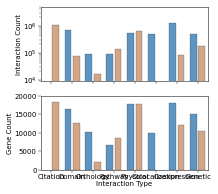

In [44]:
_, [ax, ax1] = plt.subplots(nrows=2, ncols=1,figsize=(3,3), sharex=True)
sns.barplot(data=type_df, 
                    x='Type', y='Interaction Count', hue='Network', linewidth=0.25, ax = ax, 
                    order=['Citation', 'Domain', 'Orthology', 'Pathway', 'Physical', 'Colocalization', 'Coexpression', 'Genetic'], zorder=10,
                    legend=False, palette=['#5e94c0','#d2a686' ], hue_order=[ 'GeneMania', 'HumanNet'], gap=0.2, edgecolor='#343a40', saturation=1)
ax.tick_params(labelsize=7)
ax.set_xlabel("Interaction Type", fontsize=7)
ax.set_ylabel("Interaction Count", fontsize=7)
# plot vertical line on ax
ax.set_yscale('log')
ax.set_ylim(9e3, 5e6)
sns.barplot(data=type_df, 
                    x='Type', y='Gene Count', hue='Network', linewidth=0.25, ax = ax1, 
                    order=['Citation', 'Domain', 'Orthology', 'Pathway', 'Physical', 'Colocalization', 'Coexpression', 'Genetic'], zorder=10,
                    legend=False, palette=['#5e94c0','#d2a686' ], hue_order=[ 'GeneMania', 'HumanNet'], gap=0.2, edgecolor='#343a40', saturation=1)
ax1.tick_params(labelsize=7)
ax1.set_xlabel("Interaction Type", fontsize=7)
ax1.set_ylabel("Gene Count", fontsize=7)
# plot vertical line on ax
ax1.set_ylim(0, 20000)
plt.savefig(figdir + "FigS5D_type_specific_net_sizes.jpg", dpi=300, bbox_inches="tight")

### SFig 5E - Jaccard similarities of networks

Example analysis for calculating the Jaccard similarity of networks. 

In [56]:
def make_pair_str(geneA, geneB):
    return '_'.join([str(g) for g in sorted([int(geneA), int(geneB)])])
        
J = {}
for i, pref1 in enumerate(stats.prefixes):
    for pref2 in stats.prefixes[(i+1):]:
        edges1 = pd.read_csv(stats.edge_files[pref1], sep='\t')
        edges1['Pair'] = edges1.apply(lambda x: make_pair_str(x.Entrez_A, x.Entrez_B), axis=1)
        edges2 = pd.read_csv(stats.edge_files[pref2], sep='\t')
        edges2['Pair'] = edges2.apply(lambda x: make_pair_str(x.Entrez_A, x.Entrez_B), axis=1)
        union = edges1.merge(edges2, on='Pair', how='outer')
        intersect = edges1.merge(edges2, on='Pair', how='inner')
        J[(pref1, pref2)] = len(intersect)/len(union)        
        

In [58]:
print(J)

{('dip', 'pid2'): 0.029705554369231498, ('dip', 'wan'): 0.02932195283470071, ('pid2', 'wan'): 0.0056794541066822}
